# Machine Learning Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("../data/ML_ready.csv")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE

2024-02-15 10:50:55.847185: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
# Create array to store results of accuracy in:
models_accuracy = {}
models_f1 = {}

## Neural Network (TensorFlow)

Create split of a training data so that we can both train the model but also validate it's performance.

In [5]:
X = df.drop('Credit_Score', axis=1).values
y = df['Credit_Score'].values

y = to_categorical(y, num_classes=3) # format [0,0,1]

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=101)

Let's scale the data

In [6]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data) # fit with training data and transform training data in one step
test_data  = scaler.transform(test_data)
train_data.shape

(73920, 47)

Creating the initial model with one hidden layer.

In [7]:
model_1 = Sequential()
model_1.add(Dense(37, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(Dense(18, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(Dense(3, activation="softmax")) # use softmax to return the most probable category
model_1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor="val_accuracy",mode="max",verbose=1, patience=25) # try maximise the accuracy

2024-02-15 10:51:00.658768: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-15 10:51:00.662495: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-02-15 10:51:00.713087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-15 10:51:00.713277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.645GHz coreCount: 16 deviceMemorySize: 7.92GiB deviceMemoryBandwidth: 238.66GiB/s
2024-02-15 10:51:00.713312: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-02-15 10:51:00.753526: I tensorflow/stream_executor/platform/de

In [8]:
model_1.fit(train_data, train_labels,
            epochs = 500,
            batch_size = 512,
            validation_data = (test_data, test_labels),
            verbose = 1,
            callbacks = [early_stop])

2024-02-15 10:51:03.307685: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-02-15 10:51:03.309894: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/500


2024-02-15 10:51:04.337704: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


145/145 [==============================] - 3s 12ms/step - loss: 1.0176 - accuracy: 0.4769 - val_loss: 0.8447 - val_accuracy: 0.5863
Epoch 2/500
145/145 [==============================] - 1s 7ms/step - loss: 0.8735 - accuracy: 0.5639 - val_loss: 0.8116 - val_accuracy: 0.5958
Epoch 3/500
145/145 [==============================] - 1s 9ms/step - loss: 0.8352 - accuracy: 0.5901 - val_loss: 0.7909 - val_accuracy: 0.6223
Epoch 4/500
145/145 [==============================] - 1s 7ms/step - loss: 0.8191 - accuracy: 0.6099 - val_loss: 0.7798 - val_accuracy: 0.6330
Epoch 5/500
145/145 [==============================] - 1s 6ms/step - loss: 0.8128 - accuracy: 0.6143 - val_loss: 0.7712 - val_accuracy: 0.6425
Epoch 6/500
145/145 [==============================] - 1s 4ms/step - loss: 0.7987 - accuracy: 0.6265 - val_loss: 0.7650 - val_accuracy: 0.6475
Epoch 7/500
145/145 [==============================] - 1s 4ms/step - loss: 0.7858 - accuracy: 0.6338 - val_loss: 0.7560 - val_accuracy: 0.6541
Epoch 8/50

In [9]:
model_1.save('../models/credit_score_1.keras')

<AxesSubplot: >

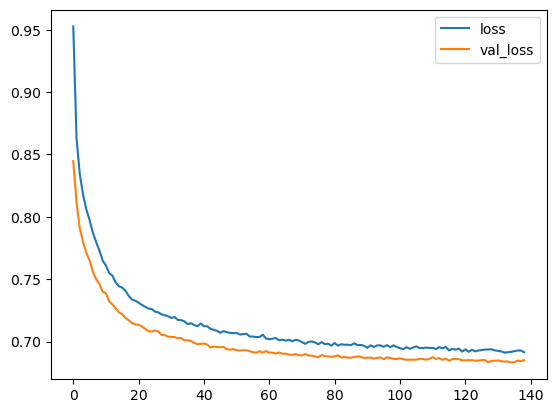

In [10]:
model_loss = pd.DataFrame(model_1.history.history)
model_loss[['loss', 'val_loss']].plot()

<AxesSubplot: >

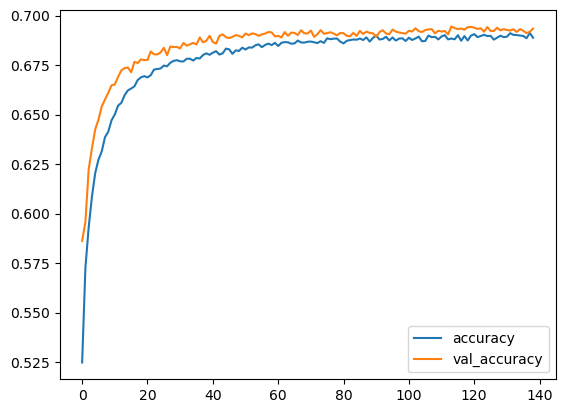

In [11]:
model_loss = pd.DataFrame(model_1.history.history)
model_loss[['accuracy', 'val_accuracy']].plot()

Getting around 69% accuracy at the looks of things...Let's try the test data

In [12]:
results = model_1.evaluate(test_data, test_labels)
print("loss = ", results[0], " with accuracy = ", results[1])
models_accuracy["Neural Network"] = results[1]

578/578 [==============================] - 2s 3ms/step - loss: 0.6849 - accuracy: 0.6934
loss =  0.6849493384361267  with accuracy =  0.6933982968330383


Text(0.5, 1.0, 'Confusion Matrix')

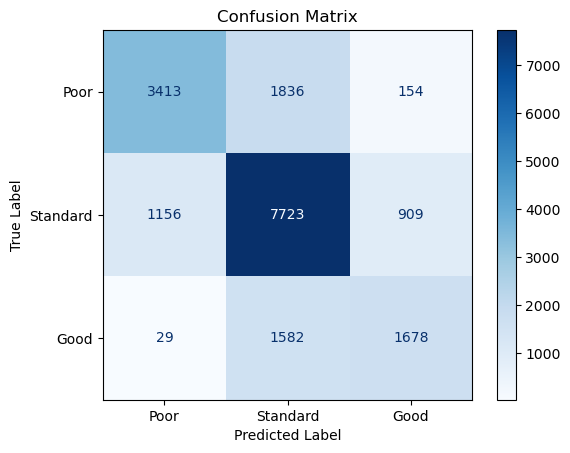

In [13]:
# Predict the values from validation dataset, predict gives probabilities, we use argmax to find the most probable
predicted_labels = np.argmax(model_1.predict(test_data), axis=1)

# Convert test labels [1, 0, 0] -> 0, [0, 1, 0] -> 1, [0, 0, 1] -> 2
true_labels = np.argmax(test_labels, axis=1)

# Compute and plot the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [14]:
print(classification_report(true_labels,predicted_labels))
models_f1["Neural Network"] = classification_report(true_labels, predicted_labels, output_dict=True)['weighted avg']['f1-score']

              precision    recall  f1-score   support

           0       0.74      0.63      0.68      5403
           1       0.69      0.79      0.74      9788
           2       0.61      0.51      0.56      3289

    accuracy                           0.69     18480
   macro avg       0.68      0.64      0.66     18480
weighted avg       0.69      0.69      0.69     18480



We see we are okay at predicting the "Standard" label and then good at predicting the "Poor" label. I think we are effected by the imbalanced credit scores.

## SMOTE

In [15]:
X = df.drop('Credit_Score', axis=1).values
y = df['Credit_Score'].values

print(np.unique(y, return_counts=True))

smote = SMOTE() # Synthetic Minority Oversampling TEchnique
X, y = smote.fit_resample(X,y)

print(np.unique(y, return_counts=True))

y = to_categorical(y, num_classes=3) # format [0,0,1]

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=101)

(array([0, 1, 2]), array([26773, 49182, 16445]))
(array([0, 1, 2]), array([49182, 49182, 49182]))


Can see the SMOTE function has sythentically brought all categories up to the same level matching Category 1 (Standard credit_score)

In [16]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data) # fit with training data and transform training data in one step
test_data  = scaler.transform(test_data)
train_data.shape

(118036, 47)

In [17]:
model_2 = Sequential()
model_2.add(Dense(37, activation="relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(18, activation="relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(3, activation="softmax")) # use softmax to return the most probable category
model_2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor="val_accuracy",mode="max",verbose=1, patience=25) # try maximise the accuracy

In [18]:
model_2.fit(train_data, train_labels,
            epochs = 500,
            batch_size = 512,
            validation_data = (test_data, test_labels),
            verbose = 1,
            callbacks = [early_stop])

Epoch 1/500
231/231 [==============================] - 3s 7ms/step - loss: 0.9957 - accuracy: 0.4972 - val_loss: 0.8189 - val_accuracy: 0.6641
Epoch 2/500
231/231 [==============================] - 1s 5ms/step - loss: 0.8407 - accuracy: 0.6424 - val_loss: 0.7877 - val_accuracy: 0.6775
Epoch 3/500
231/231 [==============================] - 1s 5ms/step - loss: 0.8128 - accuracy: 0.6604 - val_loss: 0.7683 - val_accuracy: 0.6812
Epoch 4/500
231/231 [==============================] - 1s 5ms/step - loss: 0.7931 - accuracy: 0.6717 - val_loss: 0.7571 - val_accuracy: 0.6835
Epoch 5/500
231/231 [==============================] - 1s 6ms/step - loss: 0.7812 - accuracy: 0.6760 - val_loss: 0.7456 - val_accuracy: 0.6882
Epoch 6/500
231/231 [==============================] - 1s 5ms/step - loss: 0.7727 - accuracy: 0.6778 - val_loss: 0.7358 - val_accuracy: 0.6916
Epoch 7/500
231/231 [==============================] - 1s 6ms/step - loss: 0.7650 - accuracy: 0.6811 - val_loss: 0.7283 - val_accuracy: 0.6936

In [19]:
model_2.save('../models/credit_score_SMOTE.keras')

<AxesSubplot: >

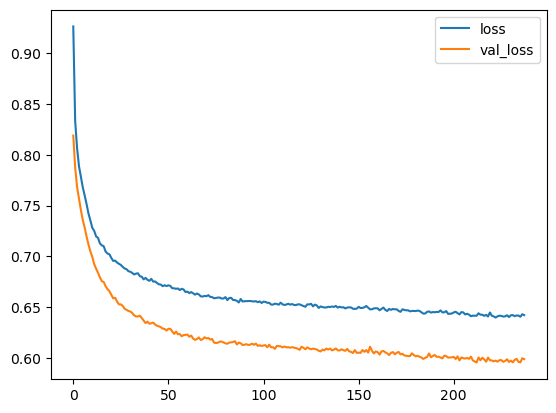

In [20]:
model_loss = pd.DataFrame(model_2.history.history)
model_loss[['loss', 'val_loss']].plot()

<AxesSubplot: >

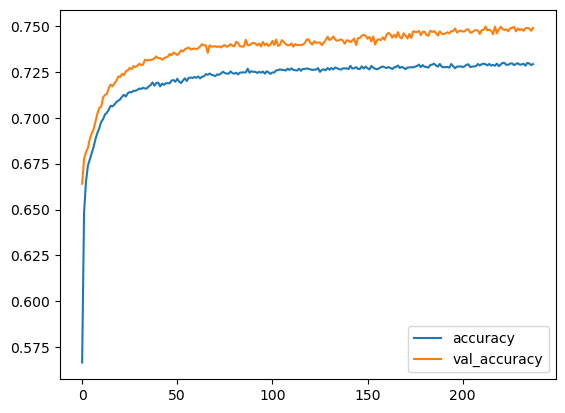

In [21]:
model_loss = pd.DataFrame(model_2.history.history)
model_loss[['accuracy', 'val_accuracy']].plot()

In [22]:
results = model_2.evaluate(test_data, test_labels)
print("loss = ", results[0], " with accuracy = ", results[1])
models_accuracy["Neural Network (SMOTE)"] = results[1]

923/923 [==============================] - 4s 4ms/step - loss: 0.5988 - accuracy: 0.7490
loss =  0.5988211631774902  with accuracy =  0.7490003108978271


An improvement from 69% before up to 75% just by correcting for the imbalanced dataset!

Text(0.5, 1.0, 'Confusion Matrix')

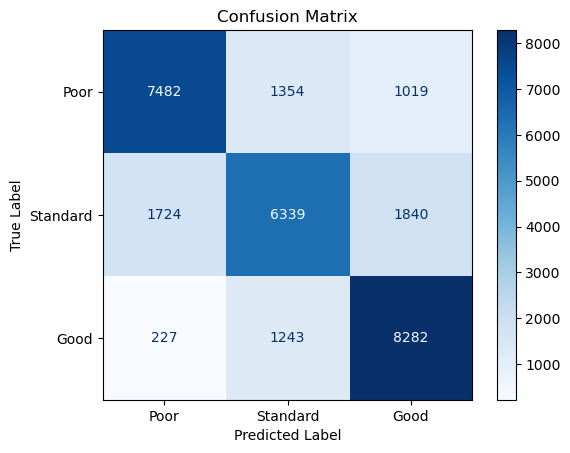

In [23]:
# Predict the values from validation dataset, predict gives probabilities, we use argmax to find the most probable
predicted_labels = np.argmax(model_2.predict(test_data), axis=1)

# Convert test labels [1, 0, 0] -> 0, [0, 1, 0] -> 1, [0, 0, 1] -> 2
true_labels = np.argmax(test_labels, axis=1)

# Compute and plot the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

Much better representation of what I expected to see. I do note that if we predict the good label and it is not actually good, then there is an equal probability of "Standard" or "Poor" being the true label, this is something definitely to be cautious of as we would not want to predict a good credit_score and give someone a loan with low interest rate when we might not get the money back!

In [24]:
print(classification_report(true_labels,predicted_labels))
models_f1["Neural Network (SMOTE)"] = classification_report(true_labels, predicted_labels, output_dict=True)['weighted avg']['f1-score']

              precision    recall  f1-score   support

           0       0.79      0.76      0.78      9855
           1       0.71      0.64      0.67      9903
           2       0.74      0.85      0.79      9752

    accuracy                           0.75     29510
   macro avg       0.75      0.75      0.75     29510
weighted avg       0.75      0.75      0.75     29510



## Scikit Learn

### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
# Reset all data
X = df.drop('Credit_Score', axis=1).values
y = df['Credit_Score'].values
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=101)

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data) # fit with training data and transform in one step
test_data  = scaler.transform(test_data)
train_data.shape

(73920, 47)

In [27]:
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(train_data, train_labels) 

LogisticRegression(max_iter=1000)

In [28]:
predicted_labels = logmodel.predict(test_data)

Text(0.5, 1.0, 'Confusion Matrix')

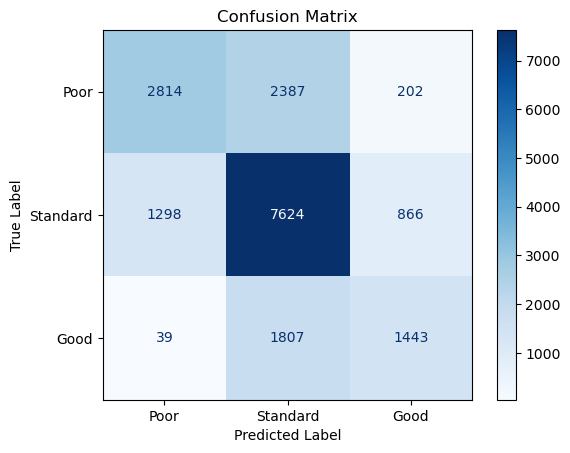

In [29]:
# Compute and plot the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [30]:
print(classification_report(test_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.68      0.52      0.59      5403
           1       0.65      0.78      0.71      9788
           2       0.57      0.44      0.50      3289

    accuracy                           0.64     18480
   macro avg       0.63      0.58      0.60     18480
weighted avg       0.64      0.64      0.63     18480



In [31]:
models_accuracy["Logistic Regression"] = classification_report(test_labels, predicted_labels, output_dict=True)['accuracy']
models_f1["Logistic Regression"]       = classification_report(test_labels, predicted_labels, output_dict=True)['weighted avg']['f1-score']


Only 64% accuracy but we'll see if the SMOTE improves things again

In [32]:
# Reset all data
X = df.drop('Credit_Score', axis=1).values
y = df['Credit_Score'].values
smote = SMOTE() # Synthetic Minority Oversampling TEchnique
X, y = smote.fit_resample(X,y)
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=101)

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data) # fit with training data and transform training data in one step
test_data  = scaler.transform(test_data)
train_data.shape

(118036, 47)

In [33]:
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(train_data, train_labels) 

LogisticRegression(max_iter=1000)

In [34]:
predicted_labels = logmodel.predict(test_data)

Text(0.5, 1.0, 'Confusion Matrix')

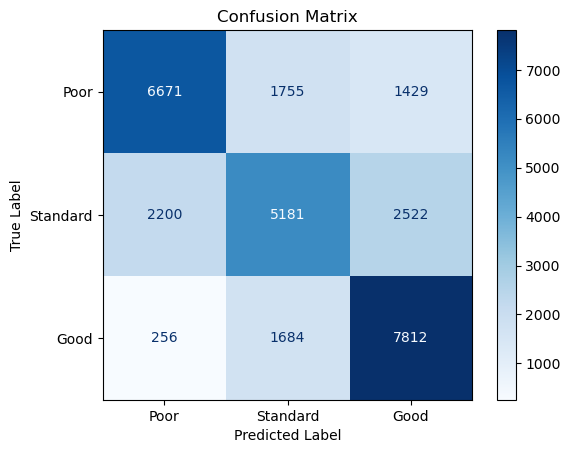

In [35]:
# Compute and plot the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [36]:
print(classification_report(test_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.73      0.68      0.70      9855
           1       0.60      0.52      0.56      9903
           2       0.66      0.80      0.73      9752

    accuracy                           0.67     29510
   macro avg       0.67      0.67      0.66     29510
weighted avg       0.67      0.67      0.66     29510



In [37]:
models_accuracy["Logistic Regression (SMOTE)"] = classification_report(test_labels, predicted_labels, output_dict=True)['accuracy']
models_f1["Logistic Regression (SMOTE)"]       = classification_report(test_labels, predicted_labels, output_dict=True)['weighted avg']['f1-score']

Up to 67% now so let's just keep using SMOTE by default

## K-Nearest Neighbours

In [38]:
from sklearn.neighbors import KNeighborsClassifier

Originally tested the algorithm with 1-50 nearest neighbours but later found this was excessive. Changed to lower value to speed up execution.

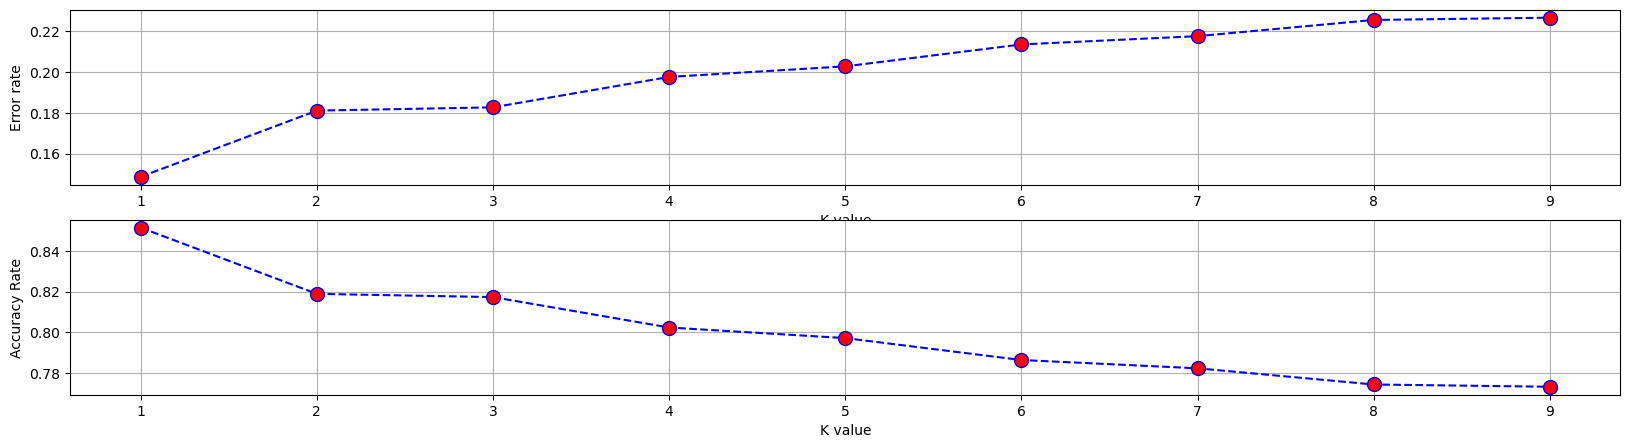

In [39]:
error_rate = []
knn_accuracy_rate = []
for nNeighbours in range(1,10): 
  knn = KNeighborsClassifier(nNeighbours)
  knn.fit(train_data, train_labels)
  predicted_labels = knn.predict(test_data)
  error_rate.append(np.mean(predicted_labels != test_labels))
  knn_accuracy_rate.append(classification_report(test_labels, predicted_labels, output_dict=True)['accuracy'])
  
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(2,1,1)
ax.plot(range(1,10), error_rate, 'b--', markerfacecolor='red', marker='o', ms=10)
ax.set_xlabel("K value")
ax.set_ylabel("Error rate")
plt.grid()

ax = fig.add_subplot(2,1,2)
ax.plot(range(1,10), knn_accuracy_rate, 'b--', markerfacecolor='red', marker='o', ms=10)
ax.set_xlabel("K value")
ax.set_ylabel("Accuracy Rate")
plt.grid()

Moving forward we choose only 1 nearest neighbour

In [40]:
knn = KNeighborsClassifier(1)
knn.fit(train_data, train_labels)
predicted_labels = knn.predict(test_data)

Text(0.5, 1.0, 'Confusion Matrix')

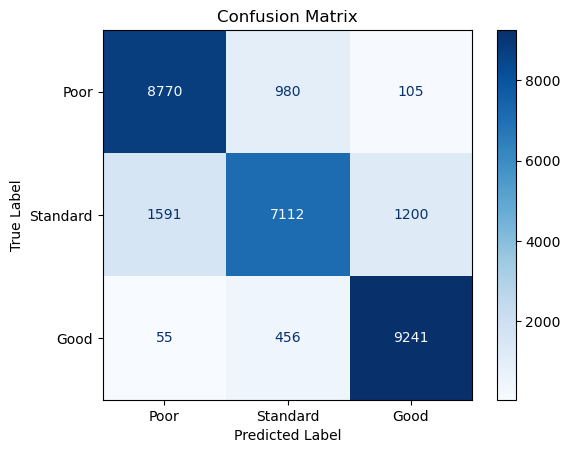

In [41]:
# Compute and plot the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [42]:
print(classification_report(test_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      9855
           1       0.83      0.72      0.77      9903
           2       0.88      0.95      0.91      9752

    accuracy                           0.85     29510
   macro avg       0.85      0.85      0.85     29510
weighted avg       0.85      0.85      0.85     29510



In [43]:
models_accuracy["KNN (SMOTE)"] = classification_report(test_labels, predicted_labels, output_dict=True)['accuracy']
models_f1["KNN (SMOTE)"]       = classification_report(test_labels, predicted_labels, output_dict=True)['weighted avg']['f1-score']

Very impressive 85% accuracy when we look for the nearest neighbour!

## SVM - LinearSVC

In [44]:
from sklearn.svm import LinearSVC

In [45]:
svc = LinearSVC()
svc.fit(train_data, train_labels)
predicted_labels = svc.predict(test_data)

Text(0.5, 1.0, 'Confusion Matrix')

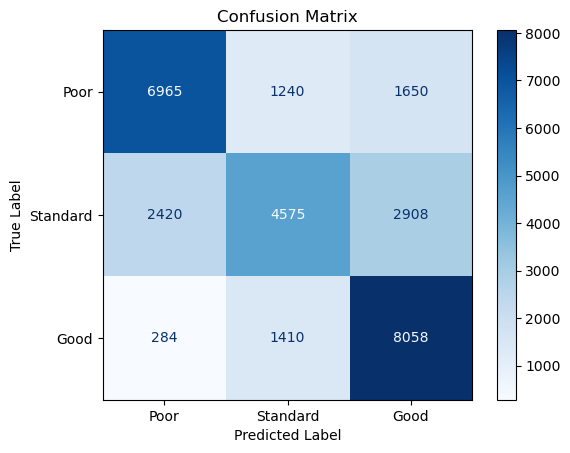

In [46]:
# Compute and plot the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [47]:
print(classification_report(test_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.72      0.71      0.71      9855
           1       0.63      0.46      0.53      9903
           2       0.64      0.83      0.72      9752

    accuracy                           0.66     29510
   macro avg       0.66      0.67      0.66     29510
weighted avg       0.66      0.66      0.66     29510



In [48]:
models_accuracy["LinearSVC (SMOTE)"] = classification_report(test_labels, predicted_labels, output_dict=True)['accuracy']
models_f1["LinearSVC (SMOTE)"]       = classification_report(test_labels, predicted_labels, output_dict=True)['weighted avg']['f1-score']

Only 67% accurate.

## Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier

In [50]:
dtree = DecisionTreeClassifier()
dtree.fit(train_data, train_labels)
predicted_labels = dtree.predict(test_data)

Text(0.5, 1.0, 'Confusion Matrix')

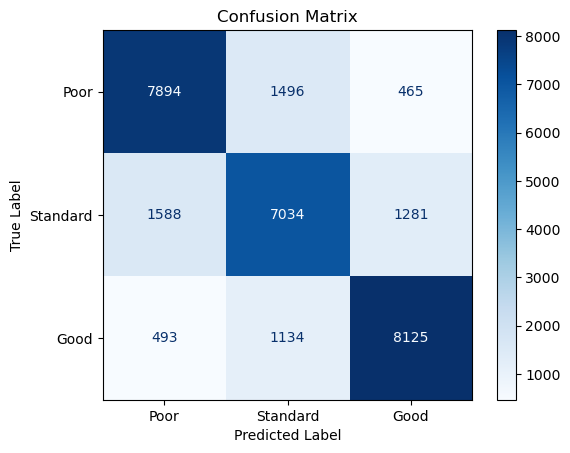

In [51]:
# Compute and plot the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [52]:
print(classification_report(test_labels,predicted_labels))
models_accuracy["Decision Tree (SMOTE)"] = classification_report(test_labels, predicted_labels, output_dict=True)['accuracy']
models_f1["Decision Tree (SMOTE)"]       = classification_report(test_labels, predicted_labels, output_dict=True)['weighted avg']['f1-score']

              precision    recall  f1-score   support

           0       0.79      0.80      0.80      9855
           1       0.73      0.71      0.72      9903
           2       0.82      0.83      0.83      9752

    accuracy                           0.78     29510
   macro avg       0.78      0.78      0.78     29510
weighted avg       0.78      0.78      0.78     29510



78% accuracy. Suprisingly good for such quick training! Does a random forest improve things?

## Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
rfc = RandomForestClassifier(n_estimators=100, random_state=101, n_jobs=8) # could play around with the number of trees here
rfc.fit(train_data, train_labels)
predicted_labels = rfc.predict(test_data)

Text(0.5, 1.0, 'Confusion Matrix')

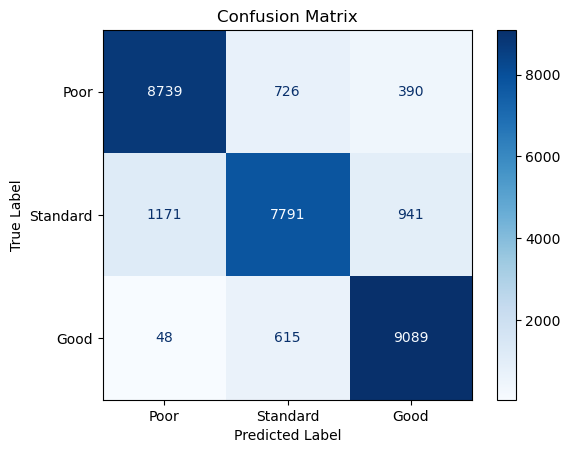

In [55]:
# Compute and plot the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [56]:
print(classification_report(test_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      9855
           1       0.85      0.79      0.82      9903
           2       0.87      0.93      0.90      9752

    accuracy                           0.87     29510
   macro avg       0.87      0.87      0.87     29510
weighted avg       0.87      0.87      0.87     29510



87% accuracy is a new best! Can we optimise the number of trees though...

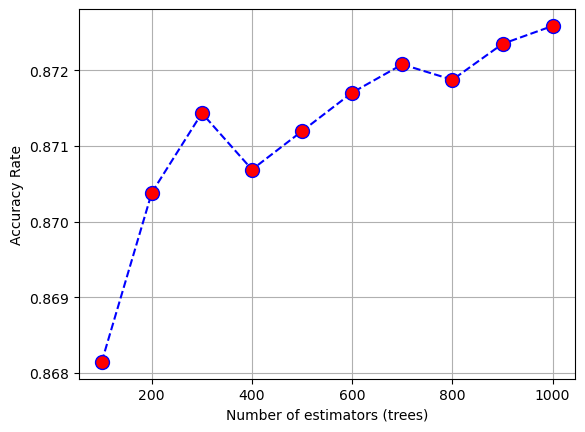

In [57]:
rfc_accuracy_rate = []
for n_estimators in range(100, 1100, 100):
  rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=101, n_jobs=8)
  rfc.fit(train_data, train_labels)
  predicted_labels = rfc.predict(test_data)
  rfc_accuracy_rate.append(classification_report(test_labels, predicted_labels, output_dict=True)['accuracy'])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(100, 1100, 100), rfc_accuracy_rate, 'b--', markerfacecolor='red', marker='o', ms=10)
ax.set_xlabel("Number of estimators (trees)")
ax.set_ylabel("Accuracy Rate")
plt.grid()

I mean very marginal gain but for a very long increased training time...

In [58]:
rfc = RandomForestClassifier(n_estimators=700, random_state=101, n_jobs=8)
rfc.fit(train_data, train_labels)
predicted_labels = rfc.predict(test_data)
models_accuracy["Random Forest (SMOTE)"] = classification_report(test_labels, predicted_labels, output_dict=True)['accuracy']
models_f1["Random Forest (SMOTE)"]       = classification_report(test_labels, predicted_labels, output_dict=True)['weighted avg']['f1-score']

## Hist Gradient Boosting Classifier

In [59]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgbc = HistGradientBoostingClassifier() 
hgbc.fit(train_data, train_labels)
predicted_labels = hgbc.predict(test_data)


Text(0.5, 1.0, 'Confusion Matrix')

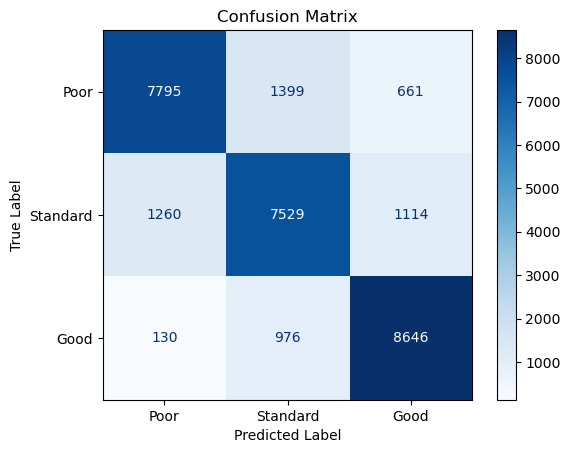

In [60]:
# Compute and plot the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [61]:
print(classification_report(test_labels,predicted_labels))
models_accuracy["HistGradientBoostingClassifier (SMOTE)"] = classification_report(test_labels, predicted_labels, output_dict=True)['accuracy']
models_f1["HistGradientBoostingClassifier (SMOTE)"]       = classification_report(test_labels, predicted_labels, output_dict=True)['weighted avg']['f1-score']

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      9855
           1       0.76      0.76      0.76      9903
           2       0.83      0.89      0.86      9752

    accuracy                           0.81     29510
   macro avg       0.81      0.81      0.81     29510
weighted avg       0.81      0.81      0.81     29510



81% accuracy so worse than random forest model.

# Results

Order dictionary with most accurate at the top

In [62]:
models_accuracy = {k: v for k, v in sorted(models_accuracy.items(), key=lambda item: item[1], reverse=True)}
models_f1       = {k: v for k, v in sorted(models_f1.items(), key=lambda item: item[1], reverse=True)}

In [63]:
print("{:<40} {:^10}".format('Method','Accuracy'))
for method, accuracy in models_accuracy.items():
  print("{:<40} {:^10.2%}".format(method, accuracy))

print("\n")
print("{:<40} {:^10}".format('Method','f1'))
for method, f1 in models_f1.items():
  print("{:<40} {:^10.2%}".format(method, f1))

Method                                    Accuracy 
Random Forest (SMOTE)                      87.21%  
KNN (SMOTE)                                85.13%  
HistGradientBoostingClassifier (SMOTE)     81.23%  
Decision Tree (SMOTE)                      78.12%  
Neural Network (SMOTE)                     74.90%  
Neural Network                             69.34%  
Logistic Regression (SMOTE)                66.64%  
LinearSVC (SMOTE)                          66.41%  
Logistic Regression                        64.29%  


Method                                       f1    
Random Forest (SMOTE)                      87.10%  
KNN (SMOTE)                                84.86%  
HistGradientBoostingClassifier (SMOTE)     81.18%  
Decision Tree (SMOTE)                      78.08%  
Neural Network (SMOTE)                     74.69%  
Neural Network                             68.95%  
Logistic Regression (SMOTE)                66.24%  
LinearSVC (SMOTE)                          65.56%  
Logistic R

## Gridsearch Random Forest Classifier
Can we fine tune the random forest hyperparameters?

In [64]:
from sklearn.model_selection import GridSearchCV

# Already tested number of estimators so let's just test max features
param_grid = {'n_estimators': [50, 700], 
              'max_features': ["sqrt", "log2"],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'random_state': [101]       
}

rfc = RandomForestClassifier()
grid = GridSearchCV(estimator=rfc, param_grid=param_grid, verbose=3, n_jobs=8)
grid.fit(train_data,train_labels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 2/5] END criterion=gini, max_features=sqrt, n_estimators=50, random_state=101;, score=0.857 total time=  58.7s
[CV 4/5] END criterion=gini, max_features=sqrt, n_estimators=50, random_state=101;, score=0.852 total time=  59.9s
[CV 3/5] END criterion=gini, max_features=sqrt, n_estimators=50, random_state=101;, score=0.856 total time= 1.0min
[CV 5/5] END criterion=gini, max_features=sqrt, n_estimators=50, random_state=101;, score=0.854 total time= 1.0min
[CV 1/5] END criterion=gini, max_features=sqrt, n_estimators=50, random_state=101;, score=0.858 total time= 1.0min
[CV 1/5] END criterion=gini, max_features=log2, n_estimators=50, random_state=101;, score=0.859 total time=  39.4s
[CV 2/5] END criterion=gini, max_features=log2, n_estimators=50, random_state=101;, score=0.857 total time=  39.0s
[CV 3/5] END criterion=gini, max_features=log2, n_estimators=50, random_state=101;, score=0.857 total time=  39.7s
[CV 4/5] END criter

/home/jack/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5] END criterion=gini, max_features=log2, n_estimators=700, random_state=101;, score=0.862 total time=12.8min
[CV 2/5] END criterion=gini, max_features=log2, n_estimators=700, random_state=101;, score=0.862 total time=13.1min
[CV 4/5] END criterion=gini, max_features=sqrt, n_estimators=700, random_state=101;, score=0.858 total time=14.5min
[CV 5/5] END criterion=gini, max_features=sqrt, n_estimators=700, random_state=101;, score=0.857 total time=14.5min
[CV 1/5] END criterion=entropy, max_features=sqrt, n_estimators=50, random_state=101;, score=0.860 total time=  56.0s
[CV 2/5] END criterion=entropy, max_features=sqrt, n_estimators=50, random_state=101;, score=0.859 total time=  54.5s
[CV 4/5] END criterion=entropy, max_features=sqrt, n_estimators=50, random_state=101;, score=0.858 total time=  50.8s
[CV 3/5] END criterion=entropy, max_features=sqrt, n_estimators=50, random_state=101;, score=0.856 total time=  57.7s
[CV 5/5] END criterion=entropy, max_features=sqrt, n_estimators=

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=8,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 700], 'random_state': [101]},
             verbose=3)

In [65]:
grid.best_params_

{'criterion': 'entropy',
 'max_features': 'log2',
 'n_estimators': 700,
 'random_state': 101}

In [66]:
rfc = RandomForestClassifier(n_estimators=700, criterion='entropy', max_features="log2", random_state=101)
rfc.fit(train_data,train_labels)
predicted_labels = rfc.predict(test_data)
print(classification_report(test_labels, predicted_labels))
print(classification_report(test_labels, predicted_labels, output_dict=True)['accuracy'])
print(classification_report(test_labels, predicted_labels, output_dict=True)['weighted avg']['f1-score'])

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      9855
           1       0.86      0.79      0.83      9903
           2       0.88      0.94      0.91      9752

    accuracy                           0.88     29510
   macro avg       0.88      0.88      0.87     29510
weighted avg       0.88      0.88      0.87     29510

0.8756014910199932
0.874540149237986


New best accuracy of 87.6% by tuning the hyperparameters of the random forest model :)